In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

# colmap_path = "/Users/derek/Desktop/colmap/360_extra_scenes/treehill/sparse/0"
colmap_path = "/home/da2986/intro_to_gaussian_splatting/treehill/sparse/0"

reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
image_num = 100

for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass

all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

print(all_points3d.shape, points_in_3d.shape)
gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path="point_clouds",
)

(52363, 3) (1697, 3)


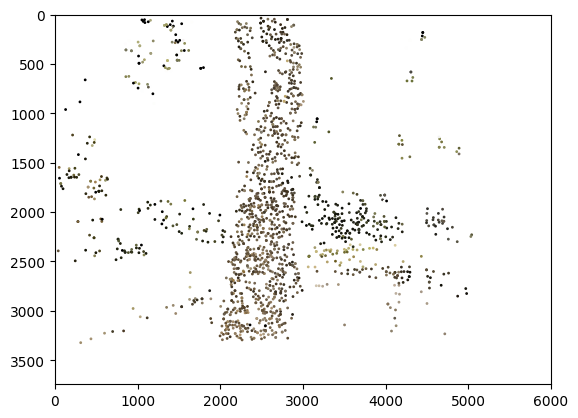

In [2]:
import matplotlib.pyplot as plt

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

In [3]:
import os
from pathlib import Path
from torch.utils.cpp_extension import load_inline

cuda_src = Path("/home/da2986/intro_to_gaussian_splatting/splat/c/render.cu").read_text()
cpp_src = """
torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity);
"""


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False):
    return load_inline(
        name="inline_ext",
        cpp_sources=[cpp_src],
        cuda_sources=[cuda_src],
        functions=funcs,
        extra_cuda_cflags=["-O1"] if opt else [],
        verbose=verbose,
    )


# Set MAX_JOBS for parallel compilation
os.environ["MAX_JOBS"] = "10"

# Compile and load the CUDA module
module = load_cuda(cuda_src, cpp_src, ["render_image"], opt=True, verbose=True)

Using /home/da2986/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Using envvar MAX_JOBS (10) as the number of workers...


[1/2] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_89,code=compute_89 -gencode=arch=compute_89,code=sm_89 --compiler-options '-fPIC' -O1 -std=c++17 -c /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/cuda.cu -o cuda

Loading extension module inline_ext...


In [5]:
import os

image = scene.render_image_cuda(image_num, tile_size=16)

Using /home/da2986/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext_v1...
Using envvar MAX_JOBS (10) as the number of workers...


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /opt/conda/lib/python3.10/site-pac

Loading extension module inline_ext_v1...


Operation took seconds:  2.4786834716796875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


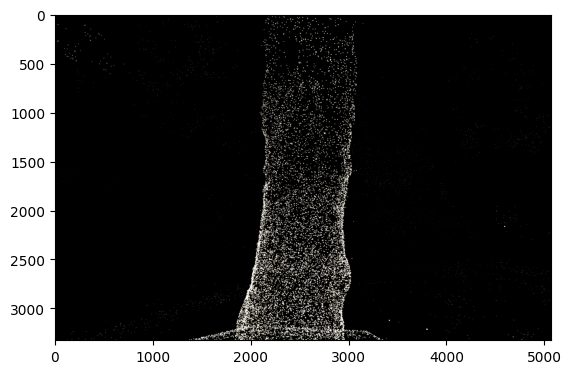

In [6]:
from matplotlib import pyplot as plt

plt.imshow(image.detach().cpu() * 256)